# Now trying to put the blocks for ITD together

## Imports

In [1]:
from bsc_package import *
import carfac.python.np.carfac as carfac

## Load/generate sound wave (L/R)

In [2]:
duration = 1.0
frequencies = [100, 500, 2460, 4808, 9000]
amplitudes = [1,1,1,1,1]
fs = 44100.0
loaded_hz = 3000

_, sig_L = generate_sine_wave(duration=duration, frequencies=frequencies, amplitudes=amplitudes, sampling_rate=fs)

sig_R = sig_L

loaded_signal, _ = librosa.load(f"Resources/Soundfiles/Binaurals/binaural_25_sine_{loaded_hz}Hz_stereo.wav", sr=fs, duration=duration, mono=False)
sig_L = loaded_signal[0]
sig_R = loaded_signal[1]


## Run signal through CARFAC and extract filter band activity

In [3]:
CF_L = carfac.design_carfac(fs=fs, n_ears=1)
CF_L = carfac.carfac_init(CF_L)

CF_R = carfac.design_carfac(fs=fs, n_ears=1)
CF_R = carfac.carfac_init(CF_R)

In [4]:
naps_L,_,BM_L,_,_ = carfac.run_segment(CF_L, input_waves=sig_L)
naps_R,_,BM_R,_,_ = carfac.run_segment(CF_R, input_waves=sig_R)

In [5]:
naps_L = BM_L
naps_R = BM_R

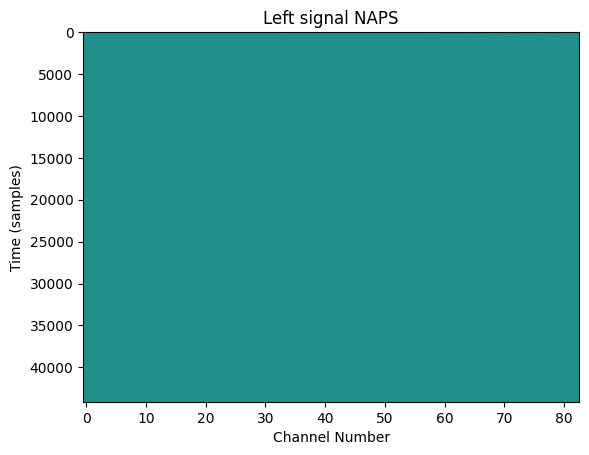

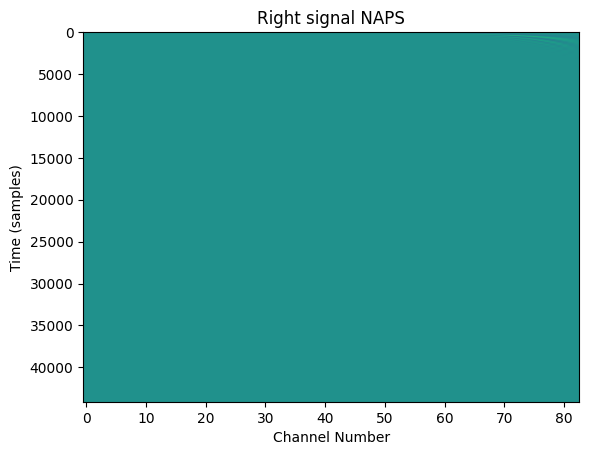

In [6]:
plot = plt.imshow(naps_L[:,: , 0], aspect='auto', origin="upper")
plt.title("Left signal NAPS")
plt.xlabel('Channel Number')
plt.ylabel('Time (samples)');
plt.show()

plot = plt.imshow(naps_R[:,: , 0], aspect='auto', origin="upper")
plt.title("Right signal NAPS")
plt.xlabel('Channel Number')
plt.ylabel('Time (samples)');

In [7]:
left_spikes_object = [None] * len(naps_L[0,:,0])
right_spikes_object = [None] * len(naps_R[0,:,0])

left_channel_spike_rate =  []
right_channel_spike_rate = []

for channel in range(len(naps_L[0,:,0])):

    # naps_L[:,channel,0] -= np.mean(naps_L[:,channel,0])
    # naps_R[:,channel,0] -= np.mean(naps_R[:,channel,0])

    left_spikes_object[channel] = activity_spike_converter(naps_L[:,channel, 0])
    right_spikes_object[channel] = activity_spike_converter(naps_R[:,channel, 0])

    left_channel_spike_rate.append(np.sum(left_spikes_object[channel])/duration)
    right_channel_spike_rate.append(np.sum(right_spikes_object[channel])/duration)



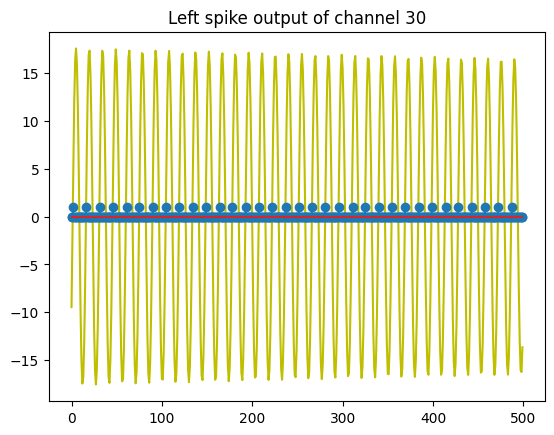

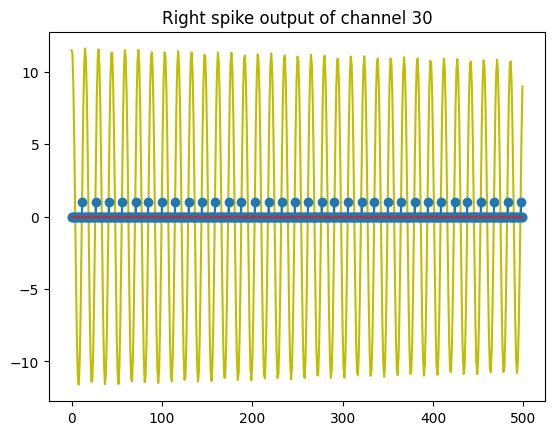

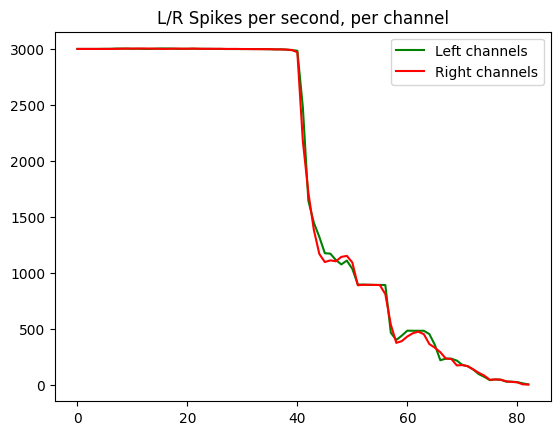

In [8]:
chnl = 30
plot_range_upper = 3000
plot_range_lower = 2500

plt.plot(naps_L[plot_range_lower:plot_range_upper, chnl], color='y')
plt.stem(left_spikes_object[chnl][plot_range_lower:plot_range_upper])
plt.title(f"Left spike output of channel {chnl}")
plt.show()

plt.plot(naps_R[plot_range_lower:plot_range_upper, chnl], color="y")
plt.stem(right_spikes_object[chnl][plot_range_lower:plot_range_upper])
plt.title(f"Right spike output of channel {chnl}")
plt.show()

plt.plot(left_channel_spike_rate, color="g")
plt.title("L/R Spikes per second, per channel")
plt.plot(right_channel_spike_rate, color="r")
plt.legend(["Left channels" , "Right channels"])
plt.show()

## Put band activity through TTR

New TTR approach is needed. Start with a simplified version!

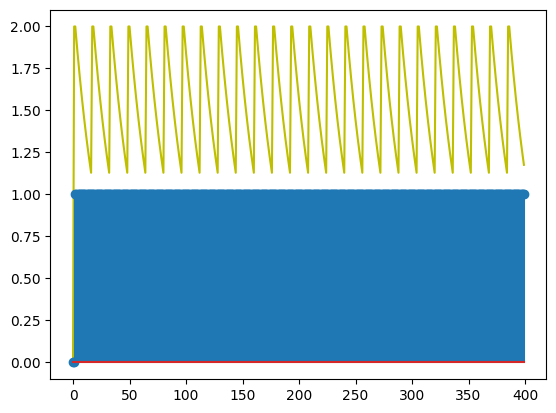

398


In [55]:
tde1 = TDE(decay_params=[2,0.04,100], LIF_params=[1, 0.97, 1, 0])
 
signal_left, signal_right = spike_arr_gen("left", delay_steps=0, period=16, num_steps=400)


tde_mem = []

tde_spks = []

for step in range(len(signal_left)):
    tde_mem.append(tde1.neuron.mem)
    tde_spks.append(tde1.output)

    tde1.calculate(fac=signal_left[step], trig=signal_right[step])

plt.plot(tde_mem[:], color = "y")
plt.stem(range(len(signal_left)), tde_spks[:])
plt.show()

print(np.sum(tde_spks))

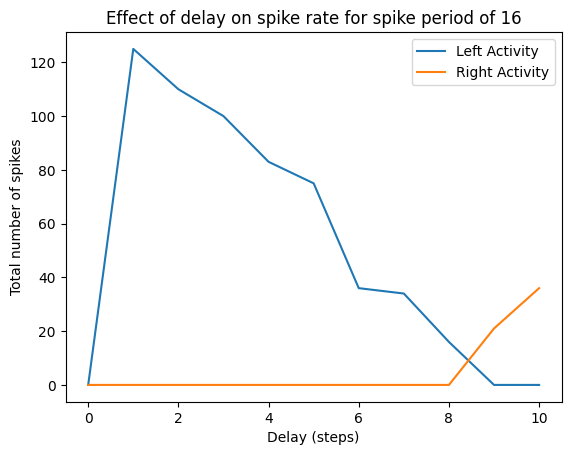

In [109]:
period = 16
delay = int(period/2 + 3)

# signal_left, signal_right = spike_arr_gen("left", delay_steps=0, period=period, num_steps=400)

tdeL1 = TDE(decay_params=[3,0.5,100], LIF_params=[1, 0.99, 1, 0])
tdeR1 = TDE(decay_params=[3,0.5,100], LIF_params=[1, 0.99, 1, 0])
tdeL2 = TDE(decay_params=[3,0.3,100], LIF_params=[1, 0.99, 1, 0])
tdeR2 = TDE(decay_params=[3,0.3,100], LIF_params=[1, 0.99, 1, 0])
tdeL3 = TDE(decay_params=[3,0.2,100], LIF_params=[1, 0.99, 1, 0])
tdeR3 = TDE(decay_params=[3,0.2,100], LIF_params=[1, 0.99, 1, 0])

tdeL4 = TDE(decay_params=[3,0.05,100], LIF_params=[1, 0.99, 1, 0])
tdeR4 = TDE(decay_params=[3,0.05,100], LIF_params=[1, 0.99, 1, 0])

lif_L = LiF(params=[1, 0.99, 1, 0])
lif_R = LiF(params=[1, 0.99, 1, 0])


spk_activity_outer = np.zeros((delay,2))

for delay in range(delay):
    
    signal_left, signal_right = spike_arr_gen("left", delay_steps=delay, period=period, num_steps=400)

    spk_activity_inner = np.zeros((len(signal_left),2))

    for step in range(len(signal_left)):

        # Baseline
        tdeL4.calculate(fac=signal_left[step], trig=signal_right[step])
        tdeR4.calculate(fac=signal_right[step], trig=signal_left[step])

        # Inhibs
        tdeL1.calculate(fac=signal_left[step], trig=signal_right[step])
        tdeL2.calculate(fac=signal_left[step], trig=signal_right[step])
        tdeL3.calculate(fac=signal_left[step], trig=signal_right[step])

        tdeR1.calculate(fac=signal_right[step], trig=signal_left[step])
        tdeR2.calculate(fac=signal_right[step], trig=signal_left[step])
        tdeR3.calculate(fac=signal_right[step], trig=signal_left[step])


        baseline_in = 1 if (tdeR4.output or tdeL4.output) else 0

        R_in = baseline_in - (tdeL1.output or tdeL2.output or tdeL3.output)
        L_in = baseline_in - (tdeR1.output or tdeR2.output or tdeR3.output)


        lif_L.run_step(L_in - R_in)
        lif_R.run_step(R_in - L_in)


        spk_activityinner[step,:] = [lif_L.spk , lif_R.spk]

    spk_activity_outer[delay, 0] = np.sum(spk_activity_inner[:,0])
    spk_activity_outer[delay, 1] = np.sum(spk_activity_inner[:,1]) 


plt.plot(spk_activity_outer)
plt.title(f"Effect of delay on spike rate for spike period of {period}")
plt.legend(["Left Activity", "Right Activity"])
plt.xlabel("Delay (steps)")
plt.ylabel("Total number of spikes")
plt.show()
